In [3]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.estimation import estimate, remove_bad_data, chi2_analysis
import pandas as pd
import numpy as np
# from tqdm import tqdm

from scipy import stats
print(pp.__version__)

import matplotlib.pyplot as plt
import ruptures as rpt

from tqdm import tqdm
from numpy import diff
# from julia.PowerModels import run_ac_opf
# from julia.PowerModels import run_ac_opf

2.0.1


In [4]:
def create_measurement_unit(df_measurement, net):
    list_value=[]
    list_std=[]
    for index, row in df_measurement.iterrows():
        if row['element_type'] =='bus':
            if row['meas_type'] =='v':
                mu= net.res_bus.iloc[row['element'],0]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='p':
                mu= net.res_bus.iloc[row['element'],2]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='q':
                mu= net.res_bus.iloc[row['element'],3]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
                
        elif row['element_type'] =='line':
            if row['side']=='from':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                    
                    
        elif row['element_type'] =='trafo':
            if row['side']=='from':
                if row['meas_type'] == 'i':
                    mu =net.res_trafo.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'p':
                    mu =net.res_trafo.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'q':
                    mu =net.res_trafo.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='i':
                    mu =net.res_trafo.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='p':
                    mu =net.res_trafo.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='q':
                    mu =net.res_trafo.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
#         print(mu)  
        value = np.random.normal(mu, sigma, 1)
        list_value.append(value[0])
        list_std.append(sigma)
    df_measurement['value']=list_value
    df_measurement['std_dev']=list_std

    for index, row in df_measurement.iterrows():
        if row['element_type']=='bus':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'])
        elif row['element_type']=='line':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'], side=row['side'])
        elif row['element_type']=='trafo':
            if row['meas_type'] in ['p','q']:
                pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                      std_dev=row['std_dev'], element=row['element'], side=row['side'])
    return df_measurement, net

In [5]:
global upper_bus_accuracy, lower_bus_accuracy, upper_line_accuracy, lower_line_accuracy, upper_trafo_accuracy, lower_trafo_accuracy
upper_bus_accuracy=1.03
lower_bus_accuracy=0.97
upper_line_accuracy=1.05
lower_line_accuracy=0.95
upper_trafo_accuracy=1.05
lower_trafo_accuracy=0.95

# simple four bus system

In [50]:
#modelling duck curve pattern for solar PV generation
scaling_for_solar=np.array([0,0,0,0,0,0,0.02,0.1,0.3,0.5,0.7,0.8,0.8,1.0,1.0,0.8,0.7,0.4,0.2,0,0,0,0,0,0])
# scaling_for_solar=np.array([np.random.normal(item, 0.01, 60) if item !=0 else np.zeros(60) for item in scaling_for_solar])
scaling_for_solar=np.array([np.random.normal(item, 0.05, 1)[0] if item !=0 else np.zeros(1)[0] for ind in range(len(scaling_for_solar)-1) for item in np.linspace(scaling_for_solar[ind], scaling_for_solar[ind+1],60)])
scaling_for_solar=np.array([value if value >0 else np.zeros(1)[0] for value in scaling_for_solar])
scaling_for_solar.shape=(1,24*60)
scaling_for_load=np.array([0.3,0.2,0.15,0.15, 0.2,0.25,
                          0.4,0.5,0.6,0.7,0.4,0.5,0.6,
                          0.7,0.65,0.55,0.55,0.6,0.7,
                          0.8,0.86,0.9,0.5,0.3])
scaling_for_load=np.array([[np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15)] for item in scaling_for_load])
scaling_for_load.shape=(1,24*60)

In [51]:
scaling_for_solar[0][800:805]=0.1
scaling_for_solar[0][705:710]=0.1
scaling_for_solar[0][677:682]=0.1

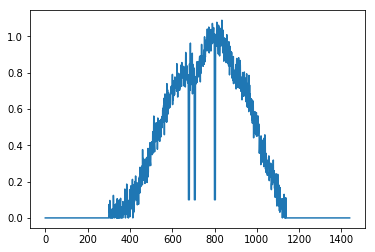

In [52]:
fig, ax = plt.subplots()

ax.plot(range(len(scaling_for_solar[0])), scaling_for_solar[0])
plt.show()

In [53]:
global upper_bus_accuracy, lower_bus_accuracy, upper_line_accuracy, lower_line_accuracy, upper_trafo_accuracy, lower_trafo_accuracy
upper_bus_accuracy=1.03
lower_bus_accuracy=0.97
upper_line_accuracy=1.05
lower_line_accuracy=0.95
upper_trafo_accuracy=1.05
lower_trafo_accuracy=0.95

In [64]:
p_mw=np.array([[0,0,0,0]])
pv_location=np.random.randint(2, size=2)
# pv_location=[0,0]
print(pv_location)
for scaling_solar, load_scaling in tqdm(zip(scaling_for_solar[0],scaling_for_load[0]), total=len(scaling_for_solar[0])):
    net = pn.simple_four_bus_system()
    net.sgen.scaling=[scaling_solar*pv_location[0], scaling_solar*pv_location[1]]
    net.sgen.q_mvar[:]=0
#     net.sgen.p_mw=[0.03,0.05]
    net.sgen.p_mw=np.random.randint(50, size=2)/1000
#     print(net.sgen.p_mw)
    net.load.scaling=[load_scaling, load_scaling]
    pp.runpp(net)
    df_measurement=pd.DataFrame()
    df_measurement['meas_type']=['v','v','p','p','q','q','i','i']
    df_measurement['element_type']=['bus','bus','line','line','line','line','line','line']
    df_measurement['element']=[2,3,0,1,0,1,0,1]
    df_measurement['side']=['None','None','from','from','from','from','from','from']
    df_measurement, net = create_measurement_unit(df_measurement, net)
    success = estimate(net, init="slack", calculate_voltage_angles=True, zero_injection=[1])
    new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
    p_mw=np.concatenate((p_mw, new_mw), axis=0)



  0%|          | 0/1440 [00:00<?, ?it/s]

[1 0]




  0%|          | 1/1440 [00:00<06:43,  3.57it/s]

  0%|          | 2/1440 [00:00<06:43,  3.56it/s]

  0%|          | 3/1440 [00:00<06:34,  3.64it/s]

  0%|          | 4/1440 [00:01<06:35,  3.63it/s]

  0%|          | 5/1440 [00:01<06:28,  3.69it/s]

  0%|          | 6/1440 [00:01<06:50,  3.50it/s]

  0%|          | 7/1440 [00:01<06:42,  3.56it/s]

  1%|          | 8/1440 [00:02<06:38,  3.59it/s]

  1%|          | 9/1440 [00:02<06:39,  3.58it/s]

  1%|          | 10/1440 [00:02<06:28,  3.68it/s]

  1%|          | 11/1440 [00:03<06:22,  3.73it/s]

  1%|          | 12/1440 [00:03<06:21,  3.74it/s]

  1%|          | 13/1440 [00:03<06:19,  3.76it/s]

  1%|          | 14/1440 [00:03<06:17,  3.77it/s]

  1%|          | 15/1440 [00:04<06:17,  3.78it/s]

  1%|          | 16/1440 [00:04<06:15,  3.79it/s]

  1%|          | 17/1440 [00:04<06:14,  3.80it/s]

  1%|▏         | 18/1440 [00:04<06:14,  3.80it/s]

  1%|▏         | 19/1440 [00:05<06:14,  3.80it/s]

  1%|▏         | 20/1440 [00:05<06:13,

 20%|█▉        | 285/1440 [01:16<05:12,  3.69it/s]

 20%|█▉        | 286/1440 [01:17<05:09,  3.73it/s]

 20%|█▉        | 287/1440 [01:17<05:05,  3.78it/s]

 20%|██        | 288/1440 [01:17<05:09,  3.72it/s]

 20%|██        | 289/1440 [01:18<05:01,  3.82it/s]

 20%|██        | 290/1440 [01:18<04:56,  3.87it/s]

 20%|██        | 291/1440 [01:18<04:56,  3.87it/s]

 20%|██        | 292/1440 [01:18<05:00,  3.82it/s]

 20%|██        | 293/1440 [01:19<05:06,  3.75it/s]

 20%|██        | 294/1440 [01:19<05:04,  3.77it/s]

 20%|██        | 295/1440 [01:19<05:11,  3.68it/s]

 21%|██        | 296/1440 [01:19<05:06,  3.73it/s]

 21%|██        | 297/1440 [01:20<05:06,  3.73it/s]

 21%|██        | 298/1440 [01:20<05:15,  3.62it/s]

 21%|██        | 299/1440 [01:20<05:14,  3.63it/s]

 21%|██        | 300/1440 [01:21<05:15,  3.62it/s]

 21%|██        | 301/1440 [01:21<05:12,  3.65it/s]

 21%|██        | 302/1440 [01:21<05:12,  3.64it/s]

 21%|██        | 303/1440 [01:21<05:10,  3.67it/s]

 21%|██     

 39%|███▉      | 567/1440 [02:34<04:04,  3.58it/s]

 39%|███▉      | 568/1440 [02:34<04:00,  3.62it/s]

 40%|███▉      | 569/1440 [02:34<03:56,  3.69it/s]

 40%|███▉      | 570/1440 [02:35<03:55,  3.70it/s]

 40%|███▉      | 571/1440 [02:35<03:52,  3.74it/s]

 40%|███▉      | 572/1440 [02:35<03:51,  3.75it/s]

 40%|███▉      | 573/1440 [02:35<03:49,  3.78it/s]

 40%|███▉      | 574/1440 [02:36<03:50,  3.75it/s]

 40%|███▉      | 575/1440 [02:36<03:50,  3.75it/s]

 40%|████      | 576/1440 [02:36<03:51,  3.73it/s]

 40%|████      | 577/1440 [02:37<03:48,  3.77it/s]

 40%|████      | 578/1440 [02:37<03:48,  3.77it/s]

 40%|████      | 579/1440 [02:37<03:47,  3.79it/s]

 40%|████      | 580/1440 [02:37<03:42,  3.86it/s]

 40%|████      | 581/1440 [02:38<03:39,  3.92it/s]

 40%|████      | 582/1440 [02:38<03:37,  3.95it/s]

 40%|████      | 583/1440 [02:38<03:37,  3.94it/s]

 41%|████      | 584/1440 [02:38<03:37,  3.94it/s]

 41%|████      | 585/1440 [02:39<03:36,  3.95it/s]

 41%|████   

 59%|█████▉    | 849/1440 [03:47<02:28,  3.99it/s]

 59%|█████▉    | 850/1440 [03:47<02:29,  3.94it/s]

 59%|█████▉    | 851/1440 [03:47<02:30,  3.92it/s]

 59%|█████▉    | 852/1440 [03:47<02:30,  3.91it/s]

 59%|█████▉    | 853/1440 [03:48<02:30,  3.91it/s]

 59%|█████▉    | 854/1440 [03:48<02:28,  3.94it/s]

 59%|█████▉    | 855/1440 [03:48<02:29,  3.91it/s]

 59%|█████▉    | 856/1440 [03:48<02:29,  3.92it/s]

 60%|█████▉    | 857/1440 [03:49<02:30,  3.87it/s]

 60%|█████▉    | 858/1440 [03:49<02:45,  3.51it/s]

 60%|█████▉    | 859/1440 [03:49<02:39,  3.64it/s]

 60%|█████▉    | 860/1440 [03:50<02:37,  3.69it/s]

 60%|█████▉    | 861/1440 [03:50<02:35,  3.72it/s]

 60%|█████▉    | 862/1440 [03:50<02:31,  3.80it/s]

 60%|█████▉    | 863/1440 [03:50<02:28,  3.88it/s]

 60%|██████    | 864/1440 [03:51<02:26,  3.93it/s]

 60%|██████    | 865/1440 [03:51<02:25,  3.96it/s]

 60%|██████    | 866/1440 [03:51<02:23,  3.99it/s]

 60%|██████    | 867/1440 [03:51<02:27,  3.88it/s]

 60%|██████ 

 78%|███████▊  | 1129/1440 [04:59<01:22,  3.77it/s]

 78%|███████▊  | 1130/1440 [04:59<01:20,  3.84it/s]

 79%|███████▊  | 1131/1440 [04:59<01:19,  3.89it/s]

 79%|███████▊  | 1132/1440 [05:00<01:18,  3.93it/s]

 79%|███████▊  | 1133/1440 [05:00<01:17,  3.97it/s]

 79%|███████▉  | 1134/1440 [05:00<01:16,  3.99it/s]

 79%|███████▉  | 1135/1440 [05:00<01:16,  4.01it/s]

 79%|███████▉  | 1136/1440 [05:01<01:15,  4.01it/s]

 79%|███████▉  | 1137/1440 [05:01<01:15,  4.02it/s]

 79%|███████▉  | 1138/1440 [05:01<01:15,  4.02it/s]

 79%|███████▉  | 1139/1440 [05:01<01:14,  4.03it/s]

 79%|███████▉  | 1140/1440 [05:01<01:14,  4.03it/s]

 79%|███████▉  | 1141/1440 [05:02<01:14,  4.04it/s]

 79%|███████▉  | 1142/1440 [05:02<01:14,  4.03it/s]

 79%|███████▉  | 1143/1440 [05:02<01:14,  4.01it/s]

 79%|███████▉  | 1144/1440 [05:02<01:14,  4.00it/s]

 80%|███████▉  | 1145/1440 [05:03<01:19,  3.71it/s]

 80%|███████▉  | 1146/1440 [05:03<01:19,  3.69it/s]

 80%|███████▉  | 1147/1440 [05:03<01:18,  3.75

 98%|█████████▊| 1405/1440 [06:09<00:08,  4.02it/s]

 98%|█████████▊| 1406/1440 [06:10<00:08,  4.01it/s]

 98%|█████████▊| 1407/1440 [06:10<00:08,  4.03it/s]

 98%|█████████▊| 1408/1440 [06:10<00:08,  3.85it/s]

 98%|█████████▊| 1409/1440 [06:10<00:09,  3.24it/s]

 98%|█████████▊| 1410/1440 [06:11<00:09,  3.21it/s]

 98%|█████████▊| 1411/1440 [06:11<00:08,  3.24it/s]

 98%|█████████▊| 1412/1440 [06:11<00:08,  3.23it/s]

 98%|█████████▊| 1413/1440 [06:12<00:08,  3.21it/s]

 98%|█████████▊| 1414/1440 [06:12<00:07,  3.36it/s]

 98%|█████████▊| 1415/1440 [06:12<00:07,  3.53it/s]

 98%|█████████▊| 1416/1440 [06:13<00:06,  3.67it/s]

 98%|█████████▊| 1417/1440 [06:13<00:06,  3.78it/s]

 98%|█████████▊| 1418/1440 [06:13<00:05,  3.83it/s]

 99%|█████████▊| 1419/1440 [06:13<00:05,  3.87it/s]

 99%|█████████▊| 1420/1440 [06:14<00:05,  3.91it/s]

 99%|█████████▊| 1421/1440 [06:14<00:04,  3.84it/s]

 99%|█████████▉| 1422/1440 [06:14<00:04,  3.66it/s]

 99%|█████████▉| 1423/1440 [06:14<00:04,  3.73

In [55]:
df=pd.DataFrame()
df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
bus_has_solar_PV=[]
for bus in range(0,len(p_mw[0])):
    df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
    print('correlation at bus {} is: {}'.format(bus, corr))
    if corr <-0.2:
        bus_has_solar_PV.append(bus)

correlation at bus 0 is: 0.7217609205897799
correlation at bus 1 is: 0.06382541173959373
correlation at bus 2 is: -0.906513234592232
correlation at bus 3 is: -0.019234579423203772


In [56]:
np.argwhere(np.isnan(p_mw))

array([], shape=(0, 2), dtype=int64)

In [57]:
# bus_has_solar_PV=[2,3]



#combine solar scaling and p_mw at solar located bus
new_p_mw=p_mw.copy()
new_p_mw=new_p_mw.transpose()
# new_p_mw[2].shape=(1441,1)
my_array=np.array([scaling_for_solar[0]]).T.copy()
for located_bus in bus_has_solar_PV:
    my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

In [58]:
algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(my_array[:])
my_bkps = algo.predict(pen=1)

In [59]:
my_bkps

[321,
 421,
 453,
 499,
 521,
 555,
 592,
 639,
 677,
 682,
 705,
 710,
 737,
 758,
 800,
 805,
 855,
 883,
 923,
 967,
 985,
 1012,
 1041,
 1068,
 1094,
 1121,
 1440]

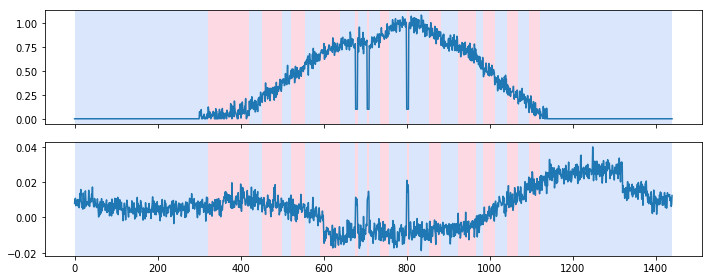

In [60]:
# display
rpt.display(my_array, my_bkps)
plt.show()

In [61]:
for bus in bus_has_solar_PV:
    sum_value=np.array([])
    for period in my_bkps[:-1]:
    #     print(period)
        value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
        if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
    #         print(value)
            sum_value = np.append(sum_value, value)
    print('bus :', bus, 'has solar PV size: ', sum_value.sum()/len(sum_value)) 

bus : 2 has solar PV size:  -0.03253468892125759


In [340]:
sum_value.sum()/len(sum_value)

-0.010217949356656396

In [389]:
net.sgen.p_mw=[30,10]



In [392]:
print(net.sgen)

  name  bus  p_mw  q_mvar  sn_mva  scaling  in_service  type  current_source
0  pv1    2    30     0.0    0.03      0.0        True  None            True
1  pv2    3    10     0.0    0.02      0.0        True  None            True


# CIGRE Task Force C6.04.02 

In [6]:
#modelling duck curve pattern for solar PV generation
scaling_for_solar=np.array([0,0,0,0,0,0,0.02,0.1,0.3,0.5,0.7,0.8,0.8,1.0,1.0,0.8,0.7,0.4,0.2,0,0,0,0,0,0])
# scaling_for_solar=np.array([np.random.normal(item, 0.01, 60) if item !=0 else np.zeros(60) for item in scaling_for_solar])
scaling_for_solar=np.array([np.random.normal(item, 0.05, 1)[0] if item !=0 else np.zeros(1)[0] for ind in range(len(scaling_for_solar)-1) for item in np.linspace(scaling_for_solar[ind], scaling_for_solar[ind+1],60)])
scaling_for_solar=np.array([value if value >0 else np.zeros(1)[0] for value in scaling_for_solar])
scaling_for_solar.shape=(1,24*60)
scaling_for_load=np.array([0.3,0.2,0.15,0.15, 0.2,0.25,
                          0.4,0.5,0.6,0.7,0.4,0.5,0.6,
                          0.7,0.65,0.55,0.55,0.6,0.7,
                          0.8,0.86,0.9,0.5,0.3])
scaling_for_load=np.array([[np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15)] for item in scaling_for_load])
scaling_for_load.shape=(1,24*60)

In [7]:
scaling_for_solar[0][800:805]=0.1
scaling_for_solar[0][705:710]=0.1
scaling_for_solar[0][677:682]=0.1

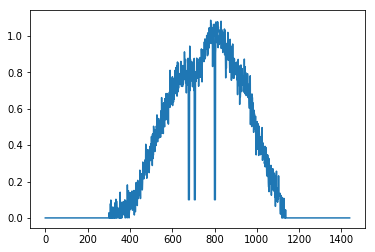

In [8]:
fig, ax = plt.subplots()

ax.plot(range(len(scaling_for_solar[0])), scaling_for_solar[0])
plt.show()

In [9]:
global upper_bus_accuracy, lower_bus_accuracy, upper_line_accuracy, lower_line_accuracy, upper_trafo_accuracy, lower_trafo_accuracy
upper_bus_accuracy=1.03
lower_bus_accuracy=0.97
upper_line_accuracy=1.05
lower_line_accuracy=0.95
upper_trafo_accuracy=1.03
lower_trafo_accuracy=0.97

In [24]:
list_bus_meas=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
list_line_meas=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
list_transfo_meas=[0,1]
df_measurement=pd.DataFrame()
df_measurement['meas_type']=['v']*len(list_bus_meas)+['p','q','i']*len(list_line_meas)+['p','q','i']*len(list_transfo_meas)
df_measurement['element_type']=['bus']*len(list_bus_meas)+['line','line','line']*len(list_line_meas)+['trafo','trafo','trafo']*len(list_transfo_meas)
df_measurement['element']=[item for item in list_bus_meas]+[item for item in list_line_meas for x in range(3)]+[item for item in list_transfo_meas for x in range(3)]
df_measurement['side']=['None']*len(list_bus_meas)+['from','from','from']*len(list_line_meas)+['to','to','to']*len(list_transfo_meas)
p_mw=np.array([np.zeros(15)])


net = pn.create_cigre_network_mv(with_der="pv_wind")
net.bus=net.bus.sort_index()
net.line=net.line.sort_index()
net.trafo=net.trafo.sort_index()
net.load=net.load.sort_index()
net.sgen=net.sgen.sort_index()
# net.shunt=net.shunt.sort_index()
net.load.drop([0,8], axis=0, inplace=True)
net.load.reset_index(drop=True, inplace=True)
net.sgen.drop([8], axis=0, inplace=True)
net.sgen.reset_index(drop=True, inplace=True)
net.switch.closed=[True]*2+[True]*2+[True]*2+[True]*2


zero_inject_bus= list(set(net.bus.index).difference(set(np.where(net.gen.p_mw!=0)[0]).union(set(net.load.bus)).union(net.ext_grid.bus).union(net.shunt.bus)))
pv_location=np.random.randint(2, size=8)

print(pv_location)
for scaling_solar, load_scaling in tqdm(zip(scaling_for_solar[0],scaling_for_load[0]), total=len(scaling_for_solar[0])):
    net.sgen.scaling=scaling_solar*pv_location
    net.load.scaling[:]=load_scaling
    pp.runpp(net)
    df_measurement, net = create_measurement_unit(df_measurement, net)
    success = estimate(net, init="flat", zero_injection=zero_inject_bus)
#     print(net.res_bus-net.res_bus_est)
    new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
    p_mw=np.concatenate((p_mw, new_mw), axis=0)


  0%|          | 0/1440 [00:00<?, ?it/s]

[0 0 1 0 0 0 0 0]



  1%|          | 16/1440 [00:08<12:33,  1.89it/s]

KeyboardInterrupt: 

In [23]:
net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,Line 1-2,CABLE_CIGRE_MV,1,2,2.82,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
1,Line 2-3,CABLE_CIGRE_MV,2,3,4.42,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
2,Line 3-4,CABLE_CIGRE_MV,3,4,0.61,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
3,Line 4-5,CABLE_CIGRE_MV,4,5,0.56,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
4,Line 5-6,CABLE_CIGRE_MV,5,6,1.54,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
5,Line 7-8,CABLE_CIGRE_MV,7,8,1.67,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
6,Line 8-9,CABLE_CIGRE_MV,8,9,0.32,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
7,Line 9-10,CABLE_CIGRE_MV,9,10,0.77,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
8,Line 10-11,CABLE_CIGRE_MV,10,11,0.33,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True
9,Line 3-8,CABLE_CIGRE_MV,3,8,1.30,0.501,0.716,151.17490,0.0,0.145,1.0,1,cs,True


In [11]:
df=pd.DataFrame()
# df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
bus_has_solar_PV=[]
for bus in range(0,len(p_mw[0])):
#     df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
    print('correlation at bus {} is: {}'.format(bus, corr))
    if corr < 0:
        bus_has_solar_PV.append(bus)

correlation at bus 0 is: -0.009498169833162996
correlation at bus 1 is: 0.011084715387450657
correlation at bus 2 is: -0.06826761056442297
correlation at bus 3 is: -0.10497366763156774
correlation at bus 4 is: -0.03946179048011897
correlation at bus 5 is: -0.03681661131257458
correlation at bus 6 is: -0.042809433173137915
correlation at bus 7 is: -0.0023289804555999966
correlation at bus 8 is: -0.013630694938479609
correlation at bus 9 is: -0.15436454637263292
correlation at bus 10 is: -0.207345266863556
correlation at bus 11 is: -0.047468256352323004
correlation at bus 12 is: 0.010586667521524285
correlation at bus 13 is: 0.02609300786256
correlation at bus 14 is: -0.05807550134902522


In [58]:
bus_has_solar_PV=[item for item in bus_has_solar_PV if item not in [0,2,13,14]]

In [12]:
bus_has_solar_PV

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14]

In [13]:
pv_location

array([1, 0, 0, 0, 0, 1, 1, 0])

In [61]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source
0,PV 3,3,0.02,0.0,0.02,0.0,True,PV,True
1,PV 4,4,0.02,0.0,0.02,0.0,True,PV,True
2,PV 5,5,0.03,0.0,0.03,0.0,True,PV,True
3,PV 6,6,0.03,0.0,0.03,0.0,True,PV,True
4,PV 8,8,0.03,0.0,0.03,0.0,True,PV,True
5,PV 9,9,0.03,0.0,0.03,0.0,True,PV,True
6,PV 10,10,0.04,0.0,0.04,0.0,True,PV,True
7,PV 11,11,0.01,0.0,0.01,0.0,True,PV,True


In [14]:
#combine solar scaling and p_mw at solar located bus
new_p_mw=p_mw.copy()
new_p_mw=new_p_mw.transpose()
my_array=np.array([scaling_for_solar[0]]).T.copy()

#add solar PV detection at bus here!!
for located_bus in bus_has_solar_PV:
    my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

In [15]:
my_array

array([[ 0.00000000e+00,  6.76884341e+00,  1.96423689e-02, ...,
         2.18121768e-01,  1.32188428e-01,  1.81450261e-01],
       [ 0.00000000e+00,  3.36782532e+00,  4.86424093e-02, ...,
         2.39867948e-01,  1.47165163e-01,  2.59159381e-01],
       [ 0.00000000e+00,  5.97008195e+00,  1.42823218e-03, ...,
         1.67832796e-01,  1.03144957e-01,  1.54655669e-01],
       ...,
       [ 0.00000000e+00,  1.43535375e+01,  2.09544542e-03, ...,
         9.99421836e-02,  5.96067991e-02,  9.46913938e-02],
       [ 0.00000000e+00,  6.42715594e+01, -3.96855501e-02, ...,
         1.66883994e-01,  9.90258108e-02,  1.62669888e-01],
       [ 0.00000000e+00, -7.79205130e+00,  1.91963112e-04, ...,
         9.10201995e-02,  5.56175641e-02,  8.61588586e-02]])

In [16]:
algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(my_array[:])
my_bkps = algo.predict(pen=1)

In [17]:
my_bkps

[7,
 10,
 16,
 21,
 24,
 35,
 37,
 55,
 57,
 59,
 69,
 71,
 73,
 76,
 79,
 81,
 87,
 95,
 97,
 101,
 108,
 110,
 122,
 128,
 139,
 147,
 151,
 153,
 155,
 168,
 170,
 173,
 175,
 189,
 198,
 201,
 208,
 223,
 228,
 232,
 234,
 239,
 254,
 264,
 270,
 274,
 283,
 289,
 298,
 302,
 304,
 308,
 310,
 325,
 327,
 336,
 338,
 342,
 363,
 366,
 371,
 375,
 443,
 446,
 452,
 465,
 467,
 475,
 551,
 553,
 556,
 582,
 584,
 607,
 609,
 611,
 615,
 635,
 639,
 647,
 650,
 675,
 682,
 686,
 696,
 698,
 768,
 773,
 880,
 884,
 910,
 912,
 925,
 939,
 941,
 976,
 980,
 983,
 986,
 1009,
 1011,
 1026,
 1028,
 1030,
 1058,
 1061,
 1093,
 1096,
 1143,
 1147,
 1149,
 1165,
 1167,
 1186,
 1193,
 1231,
 1236,
 1247,
 1249,
 1320,
 1324,
 1363,
 1365,
 1373,
 1375,
 1383,
 1389,
 1392,
 1394,
 1400,
 1403,
 1409,
 1411,
 1416,
 1419,
 1423,
 1425,
 1434,
 1440]

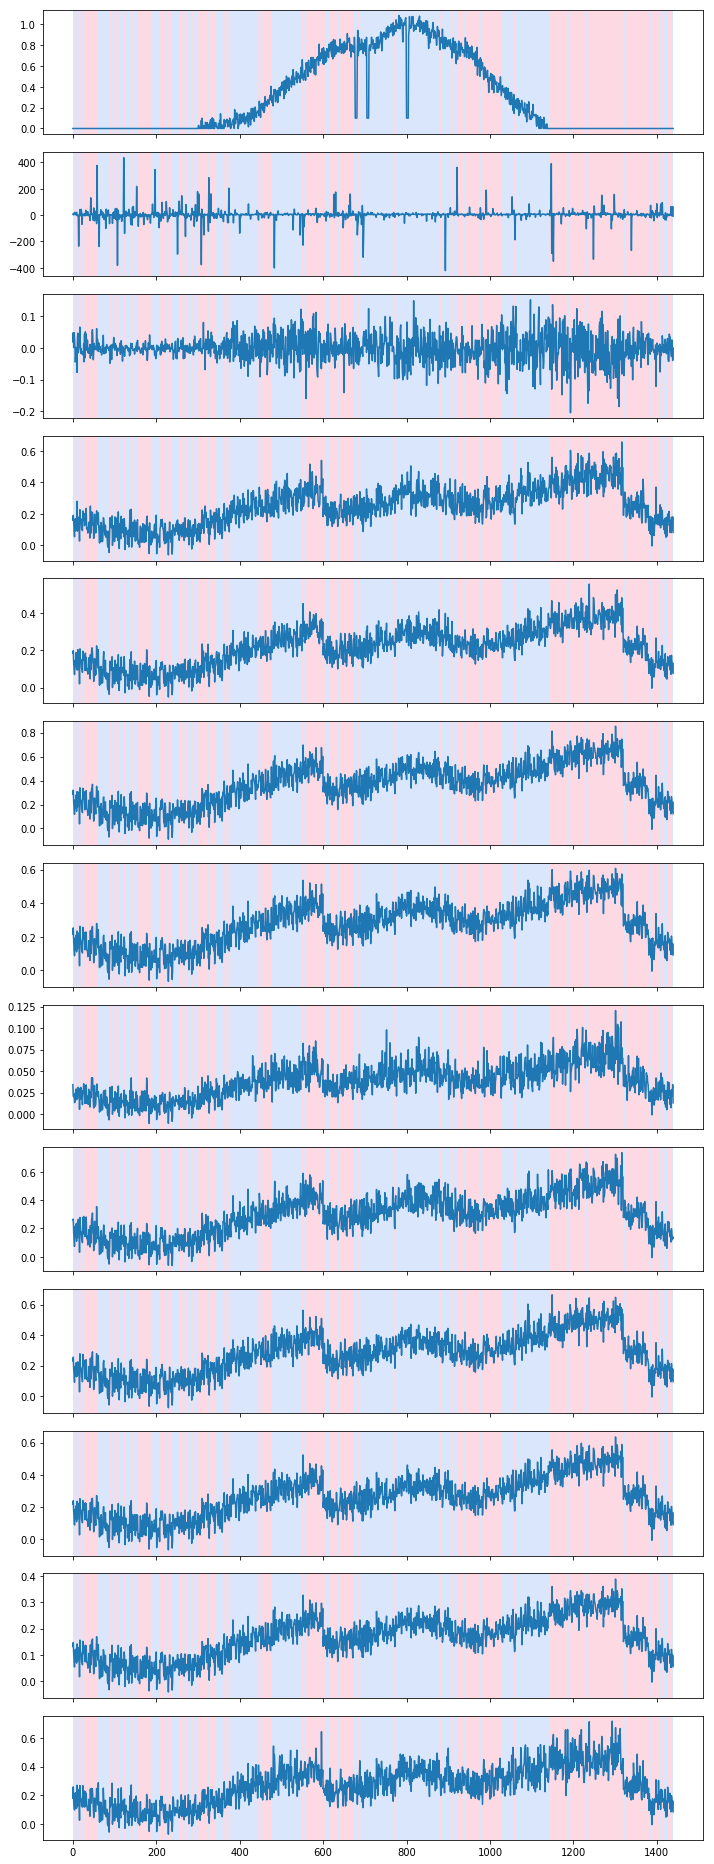

In [18]:
# display
rpt.display(my_array, my_bkps)
plt.show()

In [19]:
for bus in bus_has_solar_PV:
    sum_value=np.array([])
    for period in my_bkps[:-1]:
        value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
        if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
            sum_value = np.append(sum_value, value)
    print('bus :', bus, 'has solar PV size: ', sum_value.sum()/len(sum_value)) 

bus : 0 has solar PV size:  15441.77416985892
bus : 2 has solar PV size:  -1.9008101497387349
bus : 3 has solar PV size:  9.221875668541358
bus : 4 has solar PV size:  3.574985952931816
bus : 5 has solar PV size:  8.359603689053449
bus : 6 has solar PV size:  5.400660440652495
bus : 7 has solar PV size:  1.2819934737394272
bus : 8 has solar PV size:  6.166409351779381
bus : 9 has solar PV size:  6.565932340332231
bus : 10 has solar PV size:  5.217640770308838
bus : 11 has solar PV size:  3.5982029964001376
bus : 14 has solar PV size:  8.316950189562498


In [ ]:
-0.8313807232780226*0.08163846840673522

In [ ]:
net.sgen

# Other buses

In [4]:
#modelling duck curve pattern for solar PV generation
scaling_for_solar=np.array([0,0,0,0,0,0,0.02,0.1,0.3,0.5,0.7,0.8,0.8,1.0,1.0,0.8,0.7,0.4,0.2,0,0,0,0,0,0])
# scaling_for_solar=np.array([np.random.normal(item, 0.01, 60) if item !=0 else np.zeros(60) for item in scaling_for_solar])
scaling_for_solar=np.array([np.random.normal(item, 0.05, 1)[0] if item !=0 else np.zeros(1)[0] for ind in range(len(scaling_for_solar)-1) for item in np.linspace(scaling_for_solar[ind], scaling_for_solar[ind+1],60)])
scaling_for_solar=np.array([value if value >0 else np.zeros(1)[0] for value in scaling_for_solar])
scaling_for_solar.shape=(1,24*60)
scaling_for_load=np.array([0.3,0.2,0.15,0.15, 0.2,0.25,
                          0.4,0.5,0.6,0.7,0.4,0.5,0.6,
                          0.7,0.65,0.55,0.55,0.6,0.7,
                          0.8,0.86,0.9,0.5,0.3])
scaling_for_load=np.array([[np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15)] for item in scaling_for_load])
scaling_for_load.shape=(1,24*60)

scaling_for_solar[0][800:805]=0.1
scaling_for_solar[0][705:710]=0.1
scaling_for_solar[0][677:682]=0.1

In [5]:
fig, ax = plt.subplots()

ax.plot(range(len(scaling_for_solar[0])), scaling_for_solar[0])
plt.show()

In [25]:
net = pn.case14()
net.bus=net.bus.sort_index()
net.line=net.line.sort_index()
net.trafo=net.trafo.sort_index()
net.load=net.load.sort_index()
net.gen=net.gen.sort_index()
# net.shunt=net.shunt.sort_index()
net.gen.p_mw=net.gen.max_p_mw


zero_inject_bus= list(set(net.bus.index).difference(set(np.where(net.gen.p_mw!=0)[0]).union(set(net.load.bus)).union(net.ext_grid.bus).union(net.shunt.bus)))
list_bus_meas=list(set(net.bus.index)-set(zero_inject_bus))
list_line_meas=list(set(net.line.index))
list_transfo_meas=list(set(net.trafo.index))
df_measurement=pd.DataFrame()
df_measurement['meas_type']=['v']*len(list_bus_meas)+['p','q','p','q']*len(list_line_meas)+['p','q','p','q']*len(list_transfo_meas)
df_measurement['element_type']=['bus']*len(list_bus_meas)+['line','line','line','line']*len(list_line_meas)+['trafo','trafo','trafo','trafo']*len(list_transfo_meas)
df_measurement['element']=[item for item in list_bus_meas]+[item for item in list_line_meas for x in range(4)]+[item for item in list_transfo_meas for x in range(4)]
df_measurement['side']=['None']*len(list_bus_meas)+['from','from','to','to']*len(list_line_meas)+['from','from','to','to']*len(list_transfo_meas)

p_mw=np.array([np.zeros(len(net.bus))])
pv_location=np.random.randint(2, size=len(net.gen))
print(pv_location)

for scaling_solar, load_scalng in tqdm(zip(scaling_for_solar[0],scaling_for_load[0]), total=len(scaling_for_solar[0])):
    net.gen.scaling=scaling_solar*pv_location
    net.load.scaling[:]=load_scaling
    pp.runpp(net)
    net.res_bus=net.res_bus.sort_index()
    net.res_line=net.res_line.sort_index()
    net.res_trafo=net.res_trafo.sort_index()
    df_measurement, net = create_measurement_unit(df_measurement, net)
    success = estimate(net, init="slack", zero_injection=zero_inject_bus, calculate_voltage_angles=True)
    new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
    p_mw=np.concatenate((p_mw, new_mw), axis=0)

df=pd.DataFrame()
# df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
bus_has_solar_PV=[]
for bus in range(0,len(p_mw[0])):
#     df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
    print('correlation at bus {} is: {}'.format(bus, corr))
    if corr < 0:
        bus_has_solar_PV.append(bus)
        
# bus_has_solar_PV=[item for item in bus_has_solar_PV if item not in [0,2,13,14]]

  0%|          | 0/1440 [00:00<?, ?it/s]

[1 0 1 1]


 30%|███       | 434/1440 [05:16<12:01,  1.39it/s]/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
 33%|███▎      | 469/1440 [05:44<12:40,  1.28it/s]/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
 33%|███▎      | 477/1440 [05:50<12:20,  1.30it/s]/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
 35%|███▍      | 497/1440 [06:05<11:02,  1.42it/s]/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193

correlation at bus 0 is: 0.05406705473751935
correlation at bus 1 is: -0.05406705473820096
correlation at bus 2 is: 0.054067054740614996
correlation at bus 3 is: 0.054067054732709965
correlation at bus 4 is: 0.05406705473523987
correlation at bus 5 is: -0.05406705474604469
correlation at bus 6 is: 0.062103808919215034
correlation at bus 7 is: -0.03479633722551123
correlation at bus 8 is: -0.05406706604793629
correlation at bus 9 is: 0.05406705466651068
correlation at bus 10 is: 0.05406705471493964
correlation at bus 11 is: -0.05406705494911385
correlation at bus 12 is: 0.054067054517932936
correlation at bus 13 is: 0.05406705482121413


In [26]:
np.argwhere(np.isnan(p_mw))

array([[ 435,    0],
       [ 435,    1],
       [ 435,    2],
       [ 435,    3],
       [ 435,    4],
       [ 435,    5],
       [ 435,    6],
       [ 435,    7],
       [ 435,    8],
       [ 435,    9],
       [ 435,   10],
       [ 435,   11],
       [ 435,   12],
       [ 435,   13],
       [ 470,    0],
       [ 470,    1],
       [ 470,    2],
       [ 470,    3],
       [ 470,    4],
       [ 470,    5],
       [ 470,    6],
       [ 470,    7],
       [ 470,    8],
       [ 470,    9],
       [ 470,   10],
       [ 470,   11],
       [ 470,   12],
       [ 470,   13],
       [ 478,    0],
       [ 478,    1],
       [ 478,    2],
       [ 478,    3],
       [ 478,    4],
       [ 478,    5],
       [ 478,    6],
       [ 478,    7],
       [ 478,    8],
       [ 478,    9],
       [ 478,   10],
       [ 478,   11],
       [ 478,   12],
       [ 478,   13],
       [ 498,    0],
       [ 498,    1],
       [ 498,    2],
       [ 498,    3],
       [ 498,    4],
       [ 498,

In [29]:
#combine solar scaling and p_mw at solar located bus
new_p_mw=p_mw.copy()
new_p_mw=new_p_mw.transpose()
my_array=np.array([scaling_for_solar[0]]).T.copy()

#add solar PV detection at bus here!!
for located_bus in bus_has_solar_PV:
    my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(my_array[:])
my_bkps = algo.predict(pen=1)

print(my_bkps)

# display
rpt.display(my_array, my_bkps)
plt.show()

/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


ValueError: min() arg is an empty sequence

In [18]:
for bus in bus_has_solar_PV:
    sum_value=np.array([])
    for period in my_bkps[:-1]:
        value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
        if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
            sum_value = np.append(sum_value, value)
    print('bus :', bus, 'has solar PV size: ', sum_value.sum()/len(sum_value)) 

NameError: name 'my_bkps' is not defined

In [30]:
net = pn.case57()
net.bus=net.bus.sort_index()
net.line=net.line.sort_index()
net.trafo=net.trafo.sort_index()
net.load=net.load.sort_index()
net.gen=net.gen.sort_index()
net.shunt=net.shunt.sort_index()

net.gen.p_mw=net.gen.max_p_mw

zero_inject_bus= list(set(net.bus.index).difference(set(np.where(net.gen.p_mw!=0)[0]).union(set(net.load.bus)).union(net.ext_grid.bus).union(net.shunt.bus)))
list_bus_meas=list(set(net.bus.index)-set(zero_inject_bus))
list_line_meas=list(set(net.line.index))
list_transfo_meas=list(set(net.trafo.index))

df_measurement=pd.DataFrame()
df_measurement['meas_type']=['v']*len(list_bus_meas)+['p','q','p','q']*len(list_line_meas)+['p','q','p','q']*len(list_transfo_meas)
df_measurement['element_type']=['bus']*len(list_bus_meas)+['line','line','line','line']*len(list_line_meas)+['trafo','trafo','trafo','trafo']*len(list_transfo_meas)
df_measurement['element']=[item for item in list_bus_meas]+[item for item in list_line_meas for x in range(4)]+[item for item in list_transfo_meas for x in range(4)]
df_measurement['side']=['None']*len(list_bus_meas)+['from','from','to','to']*len(list_line_meas)+['from','from','to','to']*len(list_transfo_meas)

p_mw=np.array([np.zeros(len(net.bus))])
pv_location=np.random.randint(2, size=len(net.gen))
print(pv_location)

for scaling_solar, load_scaling in tqdm(zip(scaling_for_solar[0],scaling_for_load[0]), total=len(scaling_for_solar[0])):
    net.gen.scaling=scaling_solar*pv_location
    net.load.scaling[:]=load_scaling
    pp.runpp(net)
    net.res_bus=net.res_bus.sort_index()
    net.res_line=net.res_line.sort_index()
    net.res_trafo=net.res_trafo.sort_index()
    df_measurement, net = create_measurement_unit(df_measurement, net)
    success = estimate(net, init="flat", zero_injection=zero_inject_bus, calculate_voltage_angles=True)
    new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
    p_mw=np.concatenate((p_mw, new_mw), axis=0)

df=pd.DataFrame()
df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
bus_has_solar_PV=[]
for bus in range(0,len(p_mw[0])):
    df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
    print('correlation at bus {} is: {}'.format(bus, corr))
    if corr < 0.5:
        bus_has_solar_PV.append(bus)

        
bus_has_solar_PV=[item for item in bus_has_solar_PV if item not in [0,12, 25, 33, 44, 45]]

  0%|          | 0/1440 [00:00<?, ?it/s]

[1 0 0 1 1 0]


100%|██████████| 1440/1440 [1:03:05<00:00,  2.60s/it]

correlation at bus 0 is: 0.7997717987318733
correlation at bus 1 is: -0.9955548704310588
correlation at bus 2 is: -0.20044891116310382
correlation at bus 3 is: 5.842046719500867e-05
correlation at bus 4 is: -0.08888999291029226
correlation at bus 5 is: 0.13415597621990707
correlation at bus 6 is: -0.9127844114575944
correlation at bus 7 is: -0.9902248968727166
correlation at bus 8 is: -0.8291602911296865
correlation at bus 9 is: -0.0913851715326331
correlation at bus 10 is: -0.2783176315663567
correlation at bus 11 is: 0.025849754199686943
correlation at bus 12 is: -0.6827742535372792
correlation at bus 13 is: 0.7869432049161317
correlation at bus 14 is: 0.763666532914352
correlation at bus 15 is: -0.12681652899029253
correlation at bus 16 is: -0.09084666220821126
correlation at bus 17 is: -0.01715351271448816
correlation at bus 18 is: -0.016741762364231992
correlation at bus 19 is: -0.014525513815062244
correlation at bus 20 is: 0.9134275809633691
correlation at bus 21 is: -0.41457913

In [31]:
np.argwhere(np.isnan(p_mw))

array([], shape=(0, 2), dtype=int64)

In [41]:
df=pd.DataFrame()
df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
bus_has_solar_PV=[]
for bus in range(0,len(p_mw[0])):
    df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
    print('correlation at bus {} is: {}'.format(bus, corr))
    if corr < -0.5:
        bus_has_solar_PV.append(bus)

correlation at bus 0 is: 0.7997717987318733
correlation at bus 1 is: -0.9955548704310588
correlation at bus 2 is: -0.20044891116310382
correlation at bus 3 is: 5.842046719500867e-05
correlation at bus 4 is: -0.08888999291029226
correlation at bus 5 is: 0.13415597621990707
correlation at bus 6 is: -0.9127844114575944
correlation at bus 7 is: -0.9902248968727166
correlation at bus 8 is: -0.8291602911296865
correlation at bus 9 is: -0.0913851715326331
correlation at bus 10 is: -0.2783176315663567
correlation at bus 11 is: 0.025849754199686943
correlation at bus 12 is: -0.6827742535372792
correlation at bus 13 is: 0.7869432049161317
correlation at bus 14 is: 0.763666532914352
correlation at bus 15 is: -0.12681652899029253
correlation at bus 16 is: -0.09084666220821126
correlation at bus 17 is: -0.01715351271448816
correlation at bus 18 is: -0.016741762364231992
correlation at bus 19 is: -0.014525513815062244
correlation at bus 20 is: 0.9134275809633691
correlation at bus 21 is: -0.41457913

In [42]:
bus_has_solar_PV

[1, 6, 7, 8, 12, 25, 33, 44, 45]

In [43]:
net.gen

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar
0,1,True,True,None,100.0,0.0,NaN,None,1.010,False,100.0,0.0,50.0,-17.0
1,2,True,True,None,140.0,0.0,NaN,None,0.985,False,140.0,0.0,60.0,-10.0
2,5,True,True,None,100.0,0.0,NaN,None,0.980,False,100.0,0.0,25.0,-8.0
3,7,True,True,None,550.0,0.0,NaN,None,1.005,False,550.0,0.0,200.0,-140.0
4,8,True,True,None,100.0,0.0,NaN,None,0.980,False,100.0,0.0,9.0,-3.0
5,11,True,True,None,410.0,0.0,NaN,None,1.015,False,410.0,0.0,155.0,-150.0


[57, 360, 434, 469, 501, 523, 569, 600, 677, 682, 705, 710, 759, 800, 805, 872, 907, 960, 990, 1011, 1044, 1080, 1121, 1201, 1320, 1380, 1440]


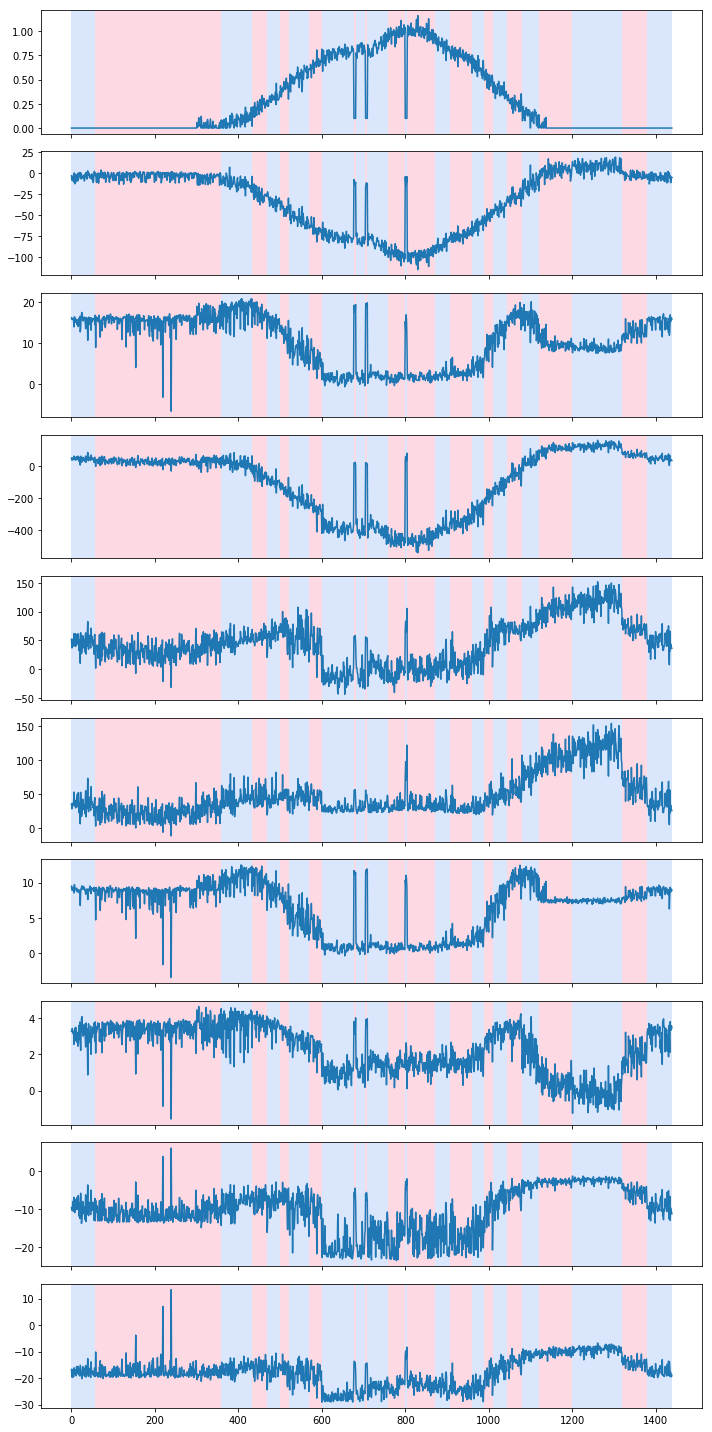

In [44]:
#combine solar scaling and p_mw at solar located bus
new_p_mw=p_mw.copy()
new_p_mw=new_p_mw.transpose()
my_array=np.array([scaling_for_solar[0]]).T.copy()

#add solar PV detection at bus here!!
for located_bus in bus_has_solar_PV:
    my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(my_array[:])
my_bkps = algo.predict(pen=1)

print(my_bkps)

# display
rpt.display(my_array, my_bkps)
plt.show()

In [45]:
for bus in bus_has_solar_PV:
    sum_value=np.array([])
    for period in my_bkps[:-1]:
        value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
        if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
            sum_value = np.append(sum_value, value)
    print('bus :', bus, 'has solar PV size: ', sum_value.sum()/len(sum_value)) 

bus : 1 has solar PV size:  -54.23231674204009
bus : 6 has solar PV size:  -15.381155283549088
bus : 7 has solar PV size:  -913.8743712908753
bus : 8 has solar PV size:  -389.781659887836
bus : 12 has solar PV size:  -437.35830991328606
bus : 25 has solar PV size:  -24.291507133172228
bus : 33 has solar PV size:  10.32242491642152
bus : 44 has solar PV size:  -55.542046624250695
bus : 45 has solar PV size:  -74.38076064001103


In [47]:
net.gen

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar
0,1,True,True,None,100.0,0.0,NaN,None,1.010,False,100.0,0.0,50.0,-17.0
1,2,True,True,None,140.0,0.0,NaN,None,0.985,False,140.0,0.0,60.0,-10.0
2,5,True,True,None,100.0,0.0,NaN,None,0.980,False,100.0,0.0,25.0,-8.0
3,7,True,True,None,550.0,0.0,NaN,None,1.005,False,550.0,0.0,200.0,-140.0
4,8,True,True,None,100.0,0.0,NaN,None,0.980,False,100.0,0.0,9.0,-3.0
5,11,True,True,None,410.0,0.0,NaN,None,1.015,False,410.0,0.0,155.0,-150.0


In [48]:
net = pn.case118()
net.bus=net.bus.sort_index()
net.line=net.line.sort_index()
net.trafo=net.trafo.sort_index()
net.load=net.load.sort_index()
net.gen=net.gen.sort_index()
net.shunt=net.shunt.sort_index()
net.gen.p_mw=net.gen.max_p_mw


zero_inject_bus= list(set(net.bus.index).difference(set(np.where(net.gen.p_mw!=0)[0]).union(set(net.load.bus)).union(net.ext_grid.bus).union(net.shunt.bus)))
list_bus_meas=list(set(net.bus.index)-set(zero_inject_bus))
list_line_meas=list(set(net.line.index))
list_transfo_meas=list(set(net.trafo.index))

df_measurement=pd.DataFrame()
df_measurement['meas_type']=['v']*len(list_bus_meas)+['p','q','p','q']*len(list_line_meas)+['p','q','p','q']*len(list_transfo_meas)
df_measurement['element_type']=['bus']*len(list_bus_meas)+['line','line','line','line']*len(list_line_meas)+['trafo','trafo','trafo','trafo']*len(list_transfo_meas)
df_measurement['element']=[item for item in list_bus_meas]+[item for item in list_line_meas for x in range(4)]+[item for item in list_transfo_meas for x in range(4)]
df_measurement['side']=['None']*len(list_bus_meas)+['from','from','to','to']*len(list_line_meas)+['from','from','to','to']*len(list_transfo_meas)
p_mw=np.array([np.zeros(len(net.bus))])
pv_location=np.random.randint(2, size=len(net.gen))
print(pv_location)

for scaling_solar, load_scaling in tqdm(zip(scaling_for_solar[0],scaling_for_load[0]), total=len(scaling_for_solar[0])):
    net.gen.scaling=scaling_solar*pv_location
    net.load.scaling[:]=load_scaling
    pp.runpp(net)
    net.res_bus=net.res_bus.sort_index()
    net.res_line=net.res_line.sort_index()
    net.res_trafo=net.res_trafo.sort_index()
    df_measurement, net = create_measurement_unit(df_measurement, net)
    success = estimate(net, init="flat", zero_injection=zero_inject_bus, calculate_voltage_angles=False)
    new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
    p_mw=np.concatenate((p_mw, new_mw), axis=0)

df=pd.DataFrame()
df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
bus_has_solar_PV=[]
for bus in range(0,len(p_mw[0])):
    df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
    corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
    print('correlation at bus {} is: {}'.format(bus, corr))
    if corr < 0:
        bus_has_solar_PV.append(bus)

        
# bus_has_solar_PV=[item for item in bus_has_solar_PV if item not in [0,2,13,14]]

  0%|          | 0/1440 [00:00<?, ?it/s]

[1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0
 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1]


/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
  0%|          | 1/1440 [00:06<2:40:00,  6.67s/it]/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
  0%|          | 2/1440 [00:12<2:35:54,  6.51s/it]/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
  0%|          | 3/1440 [00:19<2:37:44,  6.59s/it]/Users/pornchaichaweewat/anaconda3/envs/Powersystem/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:193: MatrixRankWarning: Matrix is exactly singular
  

KeyboardInterrupt: 

In [49]:
np.argwhere(np.isnan(p_mw))

array([[  1,   0],
       [  1,   1],
       [  1,   2],
       [  1,   3],
       [  1,   4],
       [  1,   5],
       [  1,   6],
       [  1,   7],
       [  1,   8],
       [  1,   9],
       [  1,  10],
       [  1,  11],
       [  1,  12],
       [  1,  13],
       [  1,  14],
       [  1,  15],
       [  1,  16],
       [  1,  17],
       [  1,  18],
       [  1,  19],
       [  1,  20],
       [  1,  21],
       [  1,  22],
       [  1,  23],
       [  1,  24],
       [  1,  25],
       [  1,  26],
       [  1,  27],
       [  1,  28],
       [  1,  29],
       [  1,  30],
       [  1,  31],
       [  1,  32],
       [  1,  33],
       [  1,  34],
       [  1,  35],
       [  1,  36],
       [  1,  37],
       [  1,  38],
       [  1,  39],
       [  1,  40],
       [  1,  41],
       [  1,  42],
       [  1,  43],
       [  1,  44],
       [  1,  45],
       [  1,  46],
       [  1,  47],
       [  1,  48],
       [  1,  49],
       [  1,  50],
       [  1,  51],
       [  1,

In [186]:
#combine solar scaling and p_mw at solar located bus
new_p_mw=p_mw.copy()
new_p_mw=new_p_mw.transpose()
my_array=np.array([scaling_for_solar[0]]).T.copy()

#add solar PV detection at bus here!!
for located_bus in bus_has_solar_PV:
    my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(my_array[:])
my_bkps = algo.predict(pen=1)

print(my_bkps)

# display
rpt.display(my_array, my_bkps)
plt.show()

,vm_pu,va_degree,p_mw,q_mvar
0,0.029447,30.507614,0.089240,0.293443
1,0.028915,30.467896,0.339776,0.163408
2,0.029140,30.454377,1.740589,0.037458
3,0.028629,30.347159,-1.352228,-0.186100
4,0.028518,30.327020,-36.494237,71.493138
5,0.028422,30.372094,3.326049,0.047474
6,0.028435,30.395735,0.251449,0.032116
7,0.035261,29.564915,352.082637,-70.105817
8,0.036599,34.831099,35.786549,-14.692540
9,0.049594,40.856601,-367.048158,-34.374007


In [ ]:
for bus in bus_has_solar_PV:
    sum_value=np.array([])
    for period in my_bkps[:-1]:
        value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
        if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
            sum_value = np.append(sum_value, value)
    print('bus :', bus, 'has solar PV size: ', sum_value.sum()/len(sum_value)) 